In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
# Add the project root (toy-wm directory) to sys.path so we can import src as a package
# This allows relative imports within the package to work correctly
# Assumes notebook is run from the project root directory
project_root = os.getcwd()  # or use: os.path.dirname(os.path.abspath(''))
print(project_root)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

/share/u/wendler/code/toy-wm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch as t

# Import using absolute path from src package
from src.utils.checkpoint import load_model_from_config

#model = load_model_from_config("configs/small_6frame.yaml")
model = load_model_from_config("configs/bigger_30frame_causal.yaml", strict=False)
model.eval()

loading configs/bigger_30frame_causal.yaml


CausalDit(
  (rope_seq): RoPE()
  (blocks): ModuleList(
    (0-7): 8 x CausalBlock(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (selfattn): AttentionEinOps(
        (rope): RoPE()
        (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (geglu): GEGLU(
        (up_proj): Linear(in_features=384, out_features=1536, bias=True)
        (up_gate): Linear(in_features=384, out_features=1536, bias=True)
        (down): Linear(in_features=1536, out_features=384, bias=True)
        (nonlin): SiLU()
      )
      (modulation): Sequential(
        (0): SiLU()
        (1): Linear(in_features=384, out_features=2304, bias=True)
      )
    )
  )
  (patch): Patch(
    (init_conv_seq): Sequential(
      (0): Conv2d(3, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): SiLU()
      (2): GroupNorm(3

In [3]:
model.activate_caching(1, 300)

torch.Size([1, 19500, 1, 32]) torch.Size([1, 19500, 1, 32])
updating rope for block 0
torch.Size([1, 1950, 1, 32]) torch.Size([1, 1950, 1, 32])
torch.Size([1, 19500, 1, 32]) torch.Size([1, 19500, 1, 32])
updating rope for block 1
torch.Size([1, 1950, 1, 32]) torch.Size([1, 1950, 1, 32])
torch.Size([1, 19500, 1, 32]) torch.Size([1, 19500, 1, 32])
updating rope for block 2
torch.Size([1, 1950, 1, 32]) torch.Size([1, 1950, 1, 32])
torch.Size([1, 19500, 1, 32]) torch.Size([1, 19500, 1, 32])
updating rope for block 3
torch.Size([1, 1950, 1, 32]) torch.Size([1, 1950, 1, 32])
torch.Size([1, 19500, 1, 32]) torch.Size([1, 19500, 1, 32])
updating rope for block 4
torch.Size([1, 1950, 1, 32]) torch.Size([1, 1950, 1, 32])
torch.Size([1, 19500, 1, 32]) torch.Size([1, 19500, 1, 32])
updating rope for block 5
torch.Size([1, 1950, 1, 32]) torch.Size([1, 1950, 1, 32])
torch.Size([1, 19500, 1, 32]) torch.Size([1, 19500, 1, 32])
updating rope for block 6
torch.Size([1, 1950, 1, 32]) torch.Size([1, 1950, 

In [4]:
from src.datasets.pong1m import get_loader

loader, pred2frame = get_loader(duration=1, fps=30, mode='-1,1')
frames, actions = next(iter(loader))
frames = pred2frame(frames)

520 batches


In [5]:
from src.trainers.diffusion_forcing import sample

def render_video(actions, n_steps=8, cfg=0, negative_actions=None, clamp=True):
    model.cache.reset()
    device = model.device
    frames = t.randn(1, actions.shape[1], 3, 24, 24, device="cpu")
    for aidx in range(actions.shape[1]):
        print(aidx)
        noise = t.randn(1, 1, 3, 24, 24, device=device)
        z = sample(model, noise, actions[:, aidx:aidx+1], num_steps=n_steps, cfg=cfg, negative_actions=negative_actions)
        model.cache.update_global_location(1)
        frames[:, aidx:aidx+1] = z.detach().cpu()
        if clamp:
            frames = frames.clamp(-1, 1)
    return frames

In [6]:
model = t.compile(model)

0


100%|██████████| 4/4 [00:49<00:00, 12.38s/it]


1


100%|██████████| 4/4 [00:12<00:00,  3.18s/it]


2


100%|██████████| 4/4 [00:11<00:00,  2.93s/it]


3


100%|██████████| 4/4 [00:11<00:00,  2.89s/it]


4


100%|██████████| 4/4 [00:11<00:00,  2.99s/it]


5


100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


6


100%|██████████| 4/4 [00:11<00:00,  2.96s/it]


7


100%|██████████| 4/4 [00:11<00:00,  2.95s/it]


8


  0%|          | 0/4 [00:00<?, ?it/s]W1105 16:35:32.203000 116706 .venv/lib/python3.13/site-packages/torch/_dynamo/convert_frame.py:1358] [0/8] torch._dynamo hit config.recompile_limit (8)
W1105 16:35:32.203000 116706 .venv/lib/python3.13/site-packages/torch/_dynamo/convert_frame.py:1358] [0/8]    function: 'forward' (/share/u/wendler/code/toy-wm/src/models/dit_dforce.py:127)
W1105 16:35:32.203000 116706 .venv/lib/python3.13/site-packages/torch/_dynamo/convert_frame.py:1358] [0/8]    last reason: 0/7: self._modules['cache'].local_loc == 455                  # return self.keys[layer_idx, :, :self.local_loc], self.values[layer_idx, :, :self.local_loc]  # src/nn/attn.py:32 in get (HINT: torch.compile considers integer attributes of the nn.Module to be static. If you are observing recompilation, you might want to make this integer dynamic using torch._dynamo.config.allow_unspec_int_on_nn_module = True, or convert this integer into a tensor.)
W1105 16:35:32.203000 116706 .venv/lib/python3.1

9


100%|██████████| 4/4 [00:00<00:00, 36.24it/s]


10


100%|██████████| 4/4 [00:00<00:00, 34.94it/s]


11


100%|██████████| 4/4 [00:00<00:00, 32.65it/s]


12


100%|██████████| 4/4 [00:00<00:00, 34.54it/s]


13


100%|██████████| 4/4 [00:00<00:00, 36.03it/s]


14


100%|██████████| 4/4 [00:00<00:00, 34.90it/s]


15


100%|██████████| 4/4 [00:00<00:00, 31.82it/s]


16


100%|██████████| 4/4 [00:00<00:00, 30.99it/s]


17


100%|██████████| 4/4 [00:00<00:00, 31.75it/s]


18


100%|██████████| 4/4 [00:00<00:00, 33.22it/s]


19


100%|██████████| 4/4 [00:00<00:00, 33.65it/s]


20


100%|██████████| 4/4 [00:00<00:00, 31.55it/s]


21


100%|██████████| 4/4 [00:00<00:00, 32.51it/s]


22


100%|██████████| 4/4 [00:00<00:00, 30.72it/s]


23


100%|██████████| 4/4 [00:00<00:00, 30.86it/s]


24


100%|██████████| 4/4 [00:00<00:00, 28.02it/s]


25


100%|██████████| 4/4 [00:00<00:00, 26.20it/s]


26


100%|██████████| 4/4 [00:00<00:00, 26.04it/s]


27


100%|██████████| 4/4 [00:00<00:00, 25.40it/s]


28


100%|██████████| 4/4 [00:00<00:00, 25.82it/s]


29


100%|██████████| 4/4 [00:00<00:00, 25.29it/s]


30


100%|██████████| 4/4 [00:00<00:00, 21.16it/s]


31


100%|██████████| 4/4 [00:00<00:00, 21.89it/s]


32


100%|██████████| 4/4 [00:00<00:00, 22.09it/s]


33


100%|██████████| 4/4 [00:00<00:00, 21.88it/s]


34


100%|██████████| 4/4 [00:00<00:00, 22.39it/s]


35


100%|██████████| 4/4 [00:00<00:00, 23.08it/s]


36


100%|██████████| 4/4 [00:00<00:00, 24.58it/s]


37


100%|██████████| 4/4 [00:00<00:00, 22.36it/s]


38


100%|██████████| 4/4 [00:00<00:00, 23.82it/s]


39


100%|██████████| 4/4 [00:00<00:00, 25.29it/s]


40


100%|██████████| 4/4 [00:00<00:00, 25.32it/s]


41


100%|██████████| 4/4 [00:00<00:00, 25.17it/s]


42


100%|██████████| 4/4 [00:00<00:00, 24.49it/s]


43


100%|██████████| 4/4 [00:00<00:00, 23.95it/s]


44


100%|██████████| 4/4 [00:00<00:00, 24.73it/s]


45


100%|██████████| 4/4 [00:00<00:00, 24.96it/s]


46


100%|██████████| 4/4 [00:00<00:00, 23.73it/s]


47


100%|██████████| 4/4 [00:00<00:00, 23.83it/s]


48


100%|██████████| 4/4 [00:00<00:00, 24.87it/s]


49


100%|██████████| 4/4 [00:00<00:00, 21.51it/s]


50


100%|██████████| 4/4 [00:00<00:00, 21.75it/s]


51


100%|██████████| 4/4 [00:00<00:00, 22.05it/s]


52


100%|██████████| 4/4 [00:00<00:00, 24.62it/s]


53


100%|██████████| 4/4 [00:00<00:00, 24.32it/s]


54


100%|██████████| 4/4 [00:00<00:00, 24.01it/s]


55


100%|██████████| 4/4 [00:00<00:00, 21.36it/s]


56


100%|██████████| 4/4 [00:00<00:00, 22.64it/s]


57


100%|██████████| 4/4 [00:00<00:00, 22.88it/s]


58


100%|██████████| 4/4 [00:00<00:00, 25.18it/s]


59


100%|██████████| 4/4 [00:00<00:00, 24.60it/s]


60


100%|██████████| 4/4 [00:00<00:00, 23.25it/s]


61


100%|██████████| 4/4 [00:00<00:00, 25.79it/s]


62


100%|██████████| 4/4 [00:00<00:00, 25.10it/s]


63


100%|██████████| 4/4 [00:00<00:00, 22.66it/s]


64


100%|██████████| 4/4 [00:00<00:00, 23.03it/s]


65


100%|██████████| 4/4 [00:00<00:00, 25.05it/s]


66


100%|██████████| 4/4 [00:00<00:00, 25.32it/s]


67


100%|██████████| 4/4 [00:00<00:00, 25.33it/s]


68


100%|██████████| 4/4 [00:00<00:00, 24.44it/s]


69


100%|██████████| 4/4 [00:00<00:00, 25.38it/s]


70


100%|██████████| 4/4 [00:00<00:00, 25.42it/s]


71


100%|██████████| 4/4 [00:00<00:00, 25.28it/s]


72


100%|██████████| 4/4 [00:00<00:00, 24.98it/s]


73


100%|██████████| 4/4 [00:00<00:00, 22.45it/s]


74


100%|██████████| 4/4 [00:00<00:00, 24.37it/s]


75


100%|██████████| 4/4 [00:00<00:00, 25.97it/s]


76


100%|██████████| 4/4 [00:00<00:00, 21.91it/s]


77


100%|██████████| 4/4 [00:00<00:00, 21.96it/s]


78


100%|██████████| 4/4 [00:00<00:00, 23.57it/s]


79


100%|██████████| 4/4 [00:00<00:00, 22.47it/s]


80


100%|██████████| 4/4 [00:00<00:00, 24.40it/s]


81


100%|██████████| 4/4 [00:00<00:00, 25.51it/s]


82


100%|██████████| 4/4 [00:00<00:00, 26.23it/s]


83


100%|██████████| 4/4 [00:00<00:00, 25.89it/s]


84


100%|██████████| 4/4 [00:00<00:00, 25.38it/s]


85


100%|██████████| 4/4 [00:00<00:00, 25.16it/s]


86


100%|██████████| 4/4 [00:00<00:00, 25.63it/s]


87


100%|██████████| 4/4 [00:00<00:00, 25.29it/s]


88


100%|██████████| 4/4 [00:00<00:00, 25.44it/s]


89


100%|██████████| 4/4 [00:00<00:00, 25.11it/s]


90


100%|██████████| 4/4 [00:00<00:00, 22.74it/s]


91


100%|██████████| 4/4 [00:00<00:00, 23.58it/s]


92


100%|██████████| 4/4 [00:00<00:00, 25.47it/s]


93


100%|██████████| 4/4 [00:00<00:00, 25.60it/s]


94


100%|██████████| 4/4 [00:00<00:00, 25.03it/s]


95


100%|██████████| 4/4 [00:00<00:00, 25.38it/s]


96


100%|██████████| 4/4 [00:00<00:00, 25.28it/s]


97


100%|██████████| 4/4 [00:00<00:00, 25.42it/s]


98


100%|██████████| 4/4 [00:00<00:00, 25.34it/s]


99


100%|██████████| 4/4 [00:00<00:00, 25.49it/s]


100


100%|██████████| 4/4 [00:00<00:00, 25.58it/s]


101


100%|██████████| 4/4 [00:00<00:00, 25.94it/s]


102


100%|██████████| 4/4 [00:00<00:00, 25.63it/s]


103


100%|██████████| 4/4 [00:00<00:00, 24.53it/s]


104


100%|██████████| 4/4 [00:00<00:00, 24.64it/s]


105


100%|██████████| 4/4 [00:00<00:00, 25.30it/s]


106


100%|██████████| 4/4 [00:00<00:00, 25.43it/s]


107


100%|██████████| 4/4 [00:00<00:00, 21.83it/s]


108


100%|██████████| 4/4 [00:00<00:00, 22.37it/s]


109


100%|██████████| 4/4 [00:00<00:00, 23.10it/s]


110


100%|██████████| 4/4 [00:00<00:00, 23.67it/s]


111


100%|██████████| 4/4 [00:00<00:00, 23.65it/s]


112


100%|██████████| 4/4 [00:00<00:00, 23.46it/s]


113


100%|██████████| 4/4 [00:00<00:00, 24.17it/s]


114


100%|██████████| 4/4 [00:00<00:00, 23.94it/s]


115


100%|██████████| 4/4 [00:00<00:00, 24.26it/s]


116


100%|██████████| 4/4 [00:00<00:00, 21.26it/s]


117


100%|██████████| 4/4 [00:00<00:00, 21.07it/s]


118


100%|██████████| 4/4 [00:00<00:00, 22.16it/s]


119


100%|██████████| 4/4 [00:00<00:00, 22.83it/s]


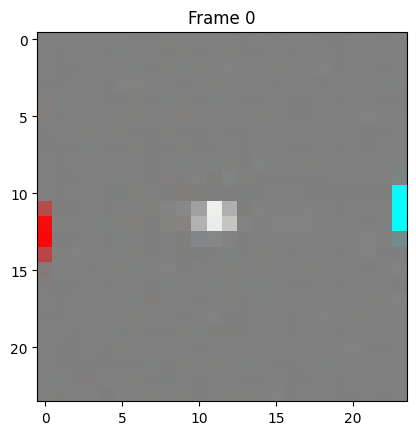

In [7]:
actions = t.tensor([[0]+119*[2]], dtype=t.int32, device=model.device)
negative_actions = t.tensor([[0]+29*[2]], dtype=t.int32, device=model.device)
z = render_video(actions, n_steps=4, cfg=0, negative_actions=None, clamp=True)
frames = pred2frame(z)

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# z[0] shape: (num_frames, height, width, 3), where num_frames = frames.shape[1]
frames_np = frames[0].permute(0, 2, 3, 1).cpu().numpy()  # shape: (num_frames, height, width, 3)

fig, ax = plt.subplots()
im = ax.imshow(frames_np[0])
ax.set_title('Frame 0')

def animate(i):
    im.set_data(frames_np[i])
    ax.set_title(f'Frame {i}')
    return [im]

ani = animation.FuncAnimation(
    fig, animate, frames=frames_np.shape[0],
    interval=200, blit=True, repeat=True
)

plt.show()

# Optional: To save the gif uncomment below (requires pillow, install with `pip install pillow`)
from collections import Counter
# Majority vote over values in actions for the filename
if actions is not None:
    # Flatten actions tensor and convert to list
    action_vals = actions.flatten().tolist()
    majority_val = Counter(action_vals).most_common(1)[0][0]
    ani.save(f"sample_{majority_val}.gif", writer="pillow")
else:
    ani.save("sample_unknown.gif", writer="pillow")


